In [393]:
import sys
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import snowflake.connector
import snowflake
import datetime as dt
import ast
import textdistance as td

In [394]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100
plt.rcParams["figure.figsize"] = (10,8)
plt.style.use('seaborn-darkgrid')

In [395]:
pdl_contact_all_params = pd.read_csv("../data/pdl_data/new_sample_contact_pdl_all_params.csv")
pdl_contact_no_mobile_phone = pd.read_csv("../data/pdl_data/new_sample_contact_pdl_no_mobile_phone.csv")
pdl_contact_no_email = pd.read_csv("../data/pdl_data/new_sample_contact_pdl_no_email.csv")
pdl_contact_no_email_and_mobile_phone = pd.read_csv("../data/pdl_data/new_sample_contact_pdl_no_email_and_mobile_phone.csv")

In [396]:
pdl_contact_all_params["LABEL"] = "ALL"
pdl_contact_no_mobile_phone["LABEL"] = "NO_PHONE"
pdl_contact_no_email["LABEL"] = "NO_EMAIL"
pdl_contact_no_email_and_mobile_phone["LABEL"] = "NO_EMAIL_PHONE"

In [397]:
pdl_contact_all = pd.concat([pdl_contact_all_params,pdl_contact_no_mobile_phone,pdl_contact_no_email,pdl_contact_no_email_and_mobile_phone]).reset_index(drop = True)

In [398]:
pdl_contact_all.groupby("LABEL")['status'].value_counts(normalize = True).to_frame('count').reset_index().query("status == 200")

,LABEL,status,count
0,ALL,200,0.690
3,NO_EMAIL,200,0.450
4,NO_EMAIL_PHONE,200,0.672
6,NO_PHONE,200,0.820


In [399]:
# email weights more than mobile phone in PDL search
# sending 2 phone numbers actually lower the likelihood score

pdl_contact_all.query("status == 200").groupby("LABEL")['likelihood'].mean()

LABEL
ALL               8.846377
NO_EMAIL          7.680000
NO_EMAIL_PHONE    6.815476
NO_PHONE          8.221951
Name: likelihood, dtype: float64

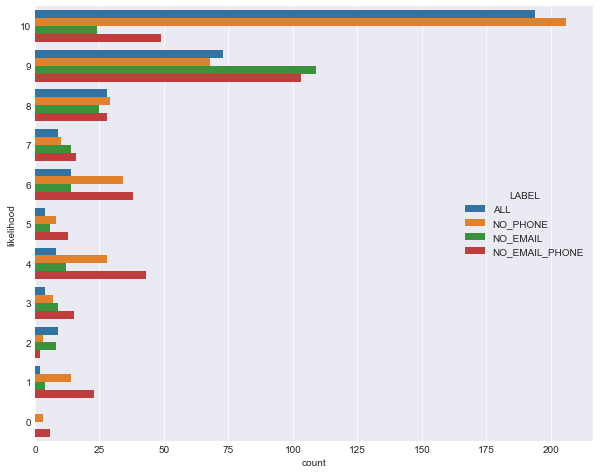

In [400]:
sns.countplot(data = pdl_contact_all, y = 'likelihood', hue='LABEL', order =[10,9,8,7,6,5,4,3,2,1,0])
plt.show()

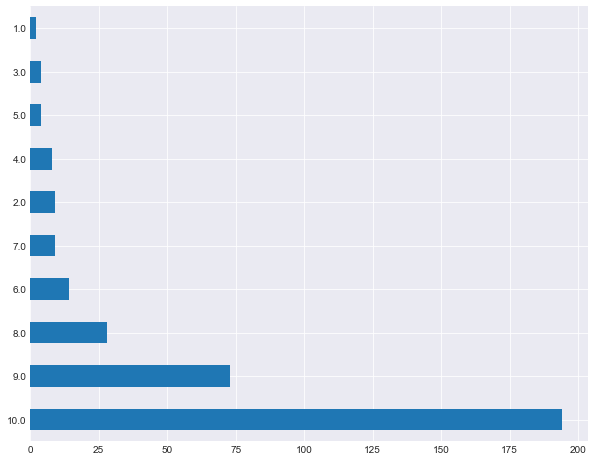

In [401]:
pdl_contact_all_params.query("status == 200")['likelihood'].value_counts().plot(kind = "barh")
plt.show()

In [402]:
# 
pdl_contact_all['matched'].value_counts()

['company', 'name']                      609
['email', 'name']                        264
['email', 'company', 'name']             111
['phone']                                111
['name']                                  63
['phone', 'company']                      59
['phone', 'name']                         36
['phone', 'company', 'name']              20
['email', 'last_name']                     9
['email', 'company']                       6
['email']                                  6
['email', 'phone', 'name']                 6
['email', 'phone', 'company', 'name']      5
['email', 'first_name']                    4
['phone', 'last_name']                     3
['email', 'company', 'last_name']          2
['phone', 'first_name']                    2
Name: matched, dtype: int64

In [403]:
pdl_contact_all.groupby("LABEL")['matched'].value_counts().to_frame('count')

count
LABEL          matched                                     
ALL            ['email', 'name']                        137
               ['company', 'name']                      122
               ['email', 'company', 'name']              58
               ['name']                                  14
               ['email', 'last_name']                     5
               ['email', 'company']                       3
               ['email']                                  3
               ['email', 'first_name']                    2
               ['email', 'company', 'last_name']          1
NO_EMAIL       ['company', 'name']                      199
               ['name']                                  26
NO_EMAIL_PHONE ['company', 'name']                      179
               ['phone']                                 69
               ['phone', 'company']                      33
               ['phone', 'name']                         23
               ['name']                                  16
               ['phone', 'company', 'name']              13
               ['phone', 'last_name']                     2
               ['phone', 'first_name']                    1
NO_PHONE       ['email', 'name']                        127
               ['company', 'name']                      109
               ['email', 'company', 'name']              53
               ['phone']                                 42
               ['phone', 'company']                      26
               ['phone', 'name']                         13
               ['name']                                   7
               ['phone', 'company', 'name']               7
               ['email', 'phone', 'name']                 6
               ['email', 'phone', 'company', 'name']      5
               ['email', 'last_name']                     4
               ['email', 'company']                       3
               ['email']                                  3
               ['email', 'first_name']                    2
               ['email', 'company', 'last_name']          1
               ['phone', 'first_name']                    1
               ['phone', 'last_name']                     1

In [404]:
# look at the data side by side (head, and also a sampling code)
# standardize the columns, and the do the match of each field

In [405]:
# [["NAME","EMAIL","PHONE","MOBILE_PHONE","COMPANY","CITY","STATE"]]
glimpse_col = ['matched',"NAME",'data.full_name',
                "EMAIL",'data.work_email',"data.personal_emails","data.emails",
                "PHONE","MOBILE_PHONE",'data.mobile_phone',"data.phone_numbers",
                "COMPANY","data.job_company_name","data.experience",
                "CITY",'data.job_company_location_locality',
                "STATE", "data.job_company_location_region"
                ]



In [406]:
pdl_contact_all[pdl_contact_all["likelihood"]== 9].sample(n = 10, random_state=1)[glimpse_col]

,matched,NAME,data.full_name,EMAIL,data.work_email,data.personal_emails,data.emails,PHONE,MOBILE_PHONE,data.mobile_phone,data.phone_numbers,COMPANY,data.job_company_name,data.experience,CITY,data.job_company_location_locality,STATE,data.job_company_location_region
1051,"['company', 'name']",angela whiteway,angela whiteway,NaN,NaN,"['angelarepros@gmail.com', 'awhiteway@aol.com'...","[{'address': 'angelarepros@gmail.com', 'type':...",310-330-3990,(310) 402-3250,NaN,['+13104023250'],SEVILLE PROPERTIES,seville properties,[{'company': {'name': 'american note/mortgage ...,INGLEWOOD,NaN,CA,NaN
1141,"['company', 'name']",conrad brightly,conrad brightly,NaN,NaN,[],[],(206) 876-1324,253-307-2105,NaN,[],Redfin Corp.,redfin,"[{'company': {'name': 'redfin', 'size': '1001-...",Everett,seattle,WA,washington
637,"['company', 'name']",athena hutt,athena hutt,athenahutthomes@gmail.com,NaN,[],"[{'address': 'ahutt@theram.com', 'type': 'prof...",(253) 904-1500,NaN,NaN,['+12535843191'],Gateway Real Estate,gateway real estate,"[{'company': {'name': 'ram restaurant group', ...",Puyallup,puyallup,WA,washington
1700,"['company', 'name']",john nalivayko,john nalivayko,NaN,NaN,[],[],(425) 615-9270,NaN,1.206931e+10,['+12069305136'],Park Place Properties,rexmont real estate group,"[{'company': {'name': 't-mobile', 'size': '100...",Puyallup,bellevue,WA,washington
1696,"['company', 'name']",marisa callaghan,marisa callaghan,NaN,NaN,[],[],(206) 971-8800,NaN,1.206660e+10,['+12066604611'],Coldwell Banker Danforth,coldwell banker danforth,[{'company': {'name': 'coldwell banker danfort...,Seattle,federal way,WA,washington
1780,"['company', 'name']",glenn d stepanovic,glenn stepanovic,NaN,NaN,[],[],(480)327-6700,NaN,NaN,[],Tru Realty,"tru realty, llc","[{'company': {'name': 'cai designs', 'size': '...",Scottsdale,scottsdale,AZ,arizona
1837,"['company', 'name']",otilia a. pena,otilia pena,NaN,NaN,[],[],(480) 893-0600,NaN,NaN,[],West Usa Realty,west usa realty,"[{'company': {'name': 'high profile realty', '...",Phoenix,phoenix,AZ,arizona
1670,"['company', 'name']",colleen walker,colleen walker,NaN,NaN,[],"[{'address': 'colleenwalker@windermere.com', '...",(253) 752-7777,NaN,NaN,[],Coldwell Banker Bain,coldwell banker bain | seal,[{'company': {'name': 'coldwell banker bain | ...,Tacoma,bellevue,WA,washington
1332,"['company', 'name']",steven a mckamey,steven mckamey,NaN,NaN,['smckamey2@msn.com'],"[{'address': 'smckamey2@msn.com', 'type': 'per...",(602) 265-4600,(602) 402-8027,NaN,['+16233768404'],PRO STAR REALTY,NaN,"[{'company': {'name': 'pro star realty', 'size...",Phoenix,NaN,AZ,NaN
1150,"['company', 'name']",jaclyn swisher,jaclyn swisher,NaN,NaN,[],"[{'address': 'jaclyn.swisher@redfin.com', 'typ...",(206) 258-6097,(425) 835-3821,NaN,[],Redfin Corp.,NaN,"[{'company': {'name': 'redfin', 'size': '1001-...",Seattle,NaN,WA,NaN


## standardize the columns

In [407]:
# todo:
# phone: extract phone from a list
# email: extract email from dict to a list 

### Name

In [408]:
# use fuzzy match (e.g Jaro Winkler) to compare the names with threshold (works in most case including nick names)

In [409]:
pdl_contact_all["NAME_STD"]= pdl_contact_all["NAME"].replace(".","").apply(lambda x: x.split(" ")[0] + " " + x.split(" ")[-1])
pdl_contact_all["data.full_name_STD"]= pdl_contact_all["data.full_name"].fillna("").replace(".","").apply(lambda x: x.split(" ")[0] + " " + x.split(" ")[-1])

In [410]:
pdl_contact_all[["NAME","data.full_name"]].sample(n = 20, random_state= 567)

,NAME,data.full_name
1436,jared steven turner,jared turner
1497,lillian leigh hermes,NaN
828,bill groen,bill groen
1827,juan c grimaldo,juan grimaldo
840,jaime auvil,jaime auvil
17,fischer lambert,fischer lambert
484,erik allen arias,erik arias
1327,juan c grimaldo,juan grimaldo
1205,stuart emery,stuart emery
1811,tamara l weber,tamara weber


In [411]:
pdl_contact_all[["NAME","data.full_name"]].sample(n = 20, random_state= 1234)

,NAME,data.full_name
1748,brenna violett,NaN
934,jose reyes,jose reyes
1033,sandy jenkins,sandy jenkins
243,nikki leske,nikki leske
928,fernando q muzquiz,fernando muzquiz
1598,jonathan mack,jonathan mack
1837,otilia a. pena,otilia pena
1709,telishia altis,NaN
1430,roberta lopez,NaN
183,timothy manchik,timothy manchik


In [412]:
td.jaro_winkler.normalized_similarity(pdl_contact_all["NAME"][21],pdl_contact_all["data.full_name"][21])

0.8733333333333333

<AxesSubplot:>

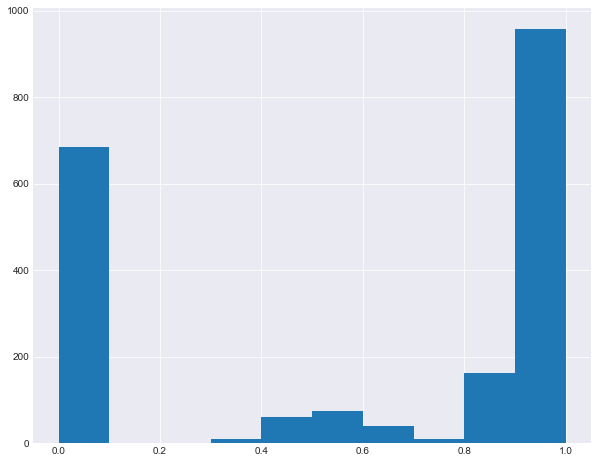

In [413]:
pdl_contact_all[['NAME','data.full_name']].fillna("").apply(lambda x: td.jaro_winkler.normalized_similarity(x['NAME'],x["data.full_name"]), axis = 1).hist()

### Phone

In [414]:
# standardize PHONE, MOBILE_PHONE, data.mobile_phone, and data.phone_numbers
# for data.phone_numbers, we standardize each number and put it back to a list

In [415]:
# pd.options.display.float_format = '{:,.0f}'.format

In [416]:
pdl_contact_all[[i for i in pdl_contact_all.columns if "PHONE" in i.upper()]]

,PHONE,MOBILE_PHONE,data.mobile_phone,data.phone_numbers
0,(818) 661-4661,(805) 750-2105,NaN,NaN
1,(818) 661-4661,(818) 687-5697,NaN,[]
2,707-541-6120,(707) 227-2122,NaN,[]
3,(310)241-3038,(310) 809-4875,NaN,NaN
4,760-863-5021,7602006360,NaN,[]
...,...,...,...,...
1995,(713) 622-1515,NaN,NaN,"['+18326590396', '+17134191871', '+17134842350..."
1996,(210) 479-1222,NaN,1.210574e+10,"['+12105738846', '+12104791222']"
1997,(623) 570-2789,NaN,1.623570e+10,"['+16235702789', '+16239340996']"
1998,(832) 434-1862,NaN,1.832434e+10,['+18324341862']


In [417]:
# check if any non-us phone exist
# PHONE: '562-249-2525 ext.1', (206) 232.0446',
# MOBILE_PHONE : '415.302.4999'
# data.mobile_phone : all 11 digit number start from 1
[i for i in pdl_contact_all["data.mobile_phone"].fillna("").astype(str) if len(re.sub(r"[\(\)\-\s]","",i)) not in [0,13]]

[]

In [418]:
# use ast.literal_eval to transform data. phone_numbers
ast.literal_eval("['+12105738846', '+12104791222']")

['+12105738846', '+12104791222']

In [419]:
# "+1" + re.sub(r"[^\bext.\d]","",'562-249-2525 ext.1')

In [420]:
def phone_std(x:str) -> str:
    if "ext" in x:
        x = x.split("ext.")[0]
    
    if x == "":
        return x
    else:
        output = re.sub("[\(\)\-\s.]","",x)
        if len(output) != 10:
            return ""
        else:
            return ("+1" + output)


In [421]:
pdl_contact_all['PHONE_STD'] = pdl_contact_all['PHONE'].apply(phone_std)

In [422]:
pdl_contact_all['MOBILE_PHONE_STD'] = pdl_contact_all['MOBILE_PHONE'].fillna("").astype(str).apply(phone_std)

In [423]:
pdl_contact_all['data.mobile_phone_STD'] = ["+"+ i if i != "0" else "" for i in pdl_contact_all["data.mobile_phone"].fillna(0).astype(int).astype(str)]

In [424]:
pdl_contact_all[["PHONE_STD","MOBILE_PHONE_STD","data.mobile_phone_STD","data.phone_numbers"]].sample(n =20, random_state= 5)

,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.phone_numbers
51,+13103303990,+13104023250,,['+13104023250']
1327,+16239398900,+14803658346,,[]
1488,+15122555050,+15127867660,,NaN
1432,+18322261399,+18324252312,,NaN
417,+12103403000,+12104176801,,NaN
269,+14808542400,+14802064680,,NaN
191,+12066127868,+14254459078,,[]
1889,+12813350335,,,NaN
1343,+14802853660,+16232433416,+16232433416,['+16232433416']
1791,+16022307600,,,[]


In [425]:
pdl_contact_all[["PHONE_STD","MOBILE_PHONE_STD","data.mobile_phone_STD"]]

,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD
0,+18186614661,+18057502105,
1,+18186614661,+18186875697,
2,+17075416120,+17072272122,
3,+13102413038,+13108094875,
4,+17608635021,+17602006360,
...,...,...,...
1995,+17136221515,,
1996,+12104791222,,+12105738846
1997,+16235702789,,+16235702789
1998,+18324341862,,+18324341862


### Email

In [426]:
pdl_contact_all[[i for i in pdl_contact_all.columns if 'EMAIL' in i.upper()]]

,EMAIL,data.work_email,data.personal_emails,data.emails
0,paige.gordon@corcorangroup.com,NaN,NaN,NaN
1,tamijo@addressrealestate.com,NaN,[],[]
2,clark@clarkharding.com,NaN,[],[{'address': 'clark.harding@chpconsulting.com'...
3,nick.schneider@compass.com,NaN,NaN,NaN
4,desertchoice@live.com,NaN,[],"[{'address': 'desertchoice@live.com', 'type': ..."
...,...,...,...,...
1995,NaN,NaN,['phylliskj@yahoo.com'],"[{'address': 'phylliskj@yahoo.com', 'type': 'p..."
1996,NaN,NaN,['smyers1222@aol.com'],"[{'address': 'scott.myers@century21.com', 'typ..."
1997,NaN,NaN,"['penate01@gmail.com', 'spenate@excite.com']","[{'address': 'penate01@gmail.com', 'type': 'pe..."
1998,NaN,NaN,[],[]


In [427]:
pdl_contact_all['data.emails_STD'] = pdl_contact_all['data.emails'].fillna("").replace("[]","").apply(lambda x: x if x == "" else str(pd.json_normalize(ast.literal_eval(x))['address'].tolist()))

In [428]:
pdl_contact_all[[i for i in pdl_contact_all.columns if 'EMAIL' in i.upper() + "data.emails_STD"]]

,EMAIL,data.work_email,data.personal_emails,data.emails,data.emails_STD
0,paige.gordon@corcorangroup.com,NaN,NaN,NaN,
1,tamijo@addressrealestate.com,NaN,[],[],
2,clark@clarkharding.com,NaN,[],[{'address': 'clark.harding@chpconsulting.com'...,['clark.harding@chpconsulting.com']
3,nick.schneider@compass.com,NaN,NaN,NaN,
4,desertchoice@live.com,NaN,[],"[{'address': 'desertchoice@live.com', 'type': ...",['desertchoice@live.com']
...,...,...,...,...,...
1995,NaN,NaN,['phylliskj@yahoo.com'],"[{'address': 'phylliskj@yahoo.com', 'type': 'p...",['phylliskj@yahoo.com']
1996,NaN,NaN,['smyers1222@aol.com'],"[{'address': 'scott.myers@century21.com', 'typ...","['scott.myers@century21.com', 'smyers1222@aol...."
1997,NaN,NaN,"['penate01@gmail.com', 'spenate@excite.com']","[{'address': 'penate01@gmail.com', 'type': 'pe...","['penate01@gmail.com', 'spenate@excite.com']"
1998,NaN,NaN,[],[],


In [429]:
pdl_contact_all[pdl_contact_all["data.work_email"].notna()][[i for i in pdl_contact_all.columns if 'EMAIL' in i.upper() + "data.emails_STD"]]

,EMAIL,data.work_email,data.personal_emails,data.emails,data.emails_STD
21,alex.baker@compass.com,alexandra.baker@gemini.com,[],"[{'address': 'alexandra.baker@gemini.com', 'ty...",['alexandra.baker@gemini.com']
22,lauren@glassesfields.com,lauren.biedenharn@compass.com,['laurenglasses@gmail.com'],"[{'address': 'laurenglasses@gmail.com', 'type'...","['laurenglasses@gmail.com', 'lbiedenh@smu.edu'..."
23,austin.vaccaro@compass.com,austin.vaccaro@compass.com,[],"[{'address': 'avaccaro@connectivity.com', 'typ...","['avaccaro@connectivity.com', 'austin.vaccaro@..."
39,jdishon@arborrealestate.com,jdishon@arborrealestate.com,[],"[{'address': 'jdishon@arborrealestate.com', 't...",['jdishon@arborrealestate.com']
69,tim@skoglinrealestate.com,tim@skoglinrealestate.com,[],"[{'address': 'tim@skoglinrealestate.com', 'typ...",['tim@skoglinrealestate.com']
...,...,...,...,...,...
1955,NaN,yolanda.trevino@realmpro.com,"['yolanda.realm@yahoo.com', 'britney_77072@hot...","[{'address': 'yolanda.realm@yahoo.com', 'type'...","['yolanda.realm@yahoo.com', 'britney_77072@gte..."
1956,NaN,jasonpardue@kw.com,['jasonpardue@hotmail.com'],"[{'address': 'jasonpardue@hotmail.com', 'type'...","['jasonpardue@hotmail.com', 'jasonpardue@kw.com']"
1975,NaN,andy@taylorrealtyassociates.com,"['turtlespringsranch@msn.com', 'andrewmcanally...","[{'address': 'turtlespringsranch@msn.com', 'ty...","['turtlespringsranch@msn.com', 'andrewmcanally..."
1984,NaN,earias@whitepicketrealty.com,[],"[{'address': 'earias@whitepicketrealty.com', '...",['earias@whitepicketrealty.com']


### State

In [430]:
# states = {
#     'AK': 'Alaska',
#     'AL': 'Alabama',
#     'AR': 'Arkansas',
#     'AS': 'American Samoa',#
#     'AZ': 'Arizona',
#     'CA': 'California',
#     'CO': 'Colorado',
#     'CT': 'Connecticut',
#     'DC': 'District of Columbia',
#     'DE': 'Delaware',
#     'FL': 'Florida',
#     'GA': 'Georgia',
#     'GU': 'Guam',#
#     'HI': 'Hawaii',
#     'IA': 'Iowa',
#     'ID': 'Idaho',
#     'IL': 'Illinois',
#     'IN': 'Indiana',
#     'KS': 'Kansas',
#     'KY': 'Kentucky',
#     'LA': 'Louisiana',
#     'MA': 'Massachusetts',
#     'MD': 'Maryland',
#     'ME': 'Maine',
#     'MI': 'Michigan',
#     'MN': 'Minnesota',
#     'MO': 'Missouri',
#     'MP': 'Northern Mariana Islands',#
#     'MS': 'Mississippi',
#     'MT': 'Montana',
#     'NC': 'North Carolina',
#     'ND': 'North Dakota',
#     'NE': 'Nebraska',
#     'NH': 'New Hampshire',
#     'NJ': 'New Jersey',
#     'NM': 'New Mexico',
#     'NV': 'Nevada',
#     'NY': 'New York',
#     'OH': 'Ohio',
#     'OK': 'Oklahoma',
#     'OR': 'Oregon',
#     'PA': 'Pennsylvania',
#     'PR': 'Puerto Rico',#
#     'RI': 'Rhode Island',
#     'SC': 'South Carolina',
#     'SD': 'South Dakota',
#     'TN': 'Tennessee',
#     'TX': 'Texas',
#     'UT': 'Utah',
#     'VA': 'Virginia',
#     'VI': 'Virgin Islands',#
#     'VT': 'Vermont',
#     'WA': 'Washington',
#     'WI': 'Wisconsin',
#     'WV': 'West Virginia',
#     'WY': 'Wyoming'
# }

# def state_std(x:str):

#     if x is None:
#         return ""

#     elif (len(x) == 2) & (x.isalpha()):
#         return x.upper()
#     else:
#         for key, value in states.items():
#             if x.lower() == value.lower():
#                 return key
#         return ""

In [431]:
# pdl_contact_all['data.job_company_location_region'].unique()

In [432]:
# pdl_contact_all['data.job_company_location_region_std'] = pdl_contact_all['data.job_company_location_region'].fillna("").apply(state_std)

In [433]:
def clean_phone(x: str) -> str:

    """
    * extract the digit only
    if length is 11, check if it starts with 1, if so, delete 1 and keep the rest;
    if length is 11 but not starts with 1, replace it with empty string
    if length is 10, pass
    all other cases will be replaced with empty string
    """

    # replace NA to empty string
    if x is None:
        x = ""
    # extract the digit only
    digits = "".join(d for d in x if d.isdigit())

    # if length ==11, check if it starts with 1, if so, delete 1 and keep the rest
    # if length ==11 and not start with 1, we treated it as invalid and just replace with empty string
    if len(digits) == 11:
        if digits[0] == "1":
            digits = digits[1:]
        else:
            digits = ""
    # if length ==10, just pass
    elif len(digits) == 10:
        pass
    # all other cases are treated as invalid and replaced with empty string
    else:
        digits = ""

    return digits


# Manual Matching

In [434]:
# matching conditions
# if emails in pdl_emails
# if jw similarity of name > threshold (0.85)
# if mobile phone in pdl_phones

In [435]:
# make 3 separate conditions
# EMAIL_MATCH: if emails in pdl_emails
# NAME_MATCH: if jw similarity of name > threshold (0.85)
# PHONE_MATCH: if mobile phone in pdl_phones

## Email Matching

In [436]:
def email_match(row):
    if row["data.emails_STD"] == "":
        return False
    elif row["EMAIL"] in ast.literal_eval(row["data.emails_STD"]):
        return True
    else:
        return False

In [437]:
pdl_contact_all["EMAIL_MATCH"] = pdl_contact_all[['EMAIL','data.emails_STD']].fillna("").apply(email_match, axis = 1)
pdl_contact_all["EMAIL_MATCH_BINARY"] = np.where(pdl_contact_all["EMAIL_MATCH"] == True, 1,0)

## Name Matching

In [438]:
pdl_contact_all[['NAME_STD','data.full_name_STD']].sample(n =20)

,NAME_STD,data.full_name_STD
425,dylan forde,
1009,leila gharache,
1872,stephanie woods,stephanie woods
500,paige gordon,
43,raquel newman,raquel newman
612,lacie roth,
326,gina petershagen,gina petershagen
1909,wanda cox,
1733,victoria marchenko,
419,dorna shirvani,


<AxesSubplot:>

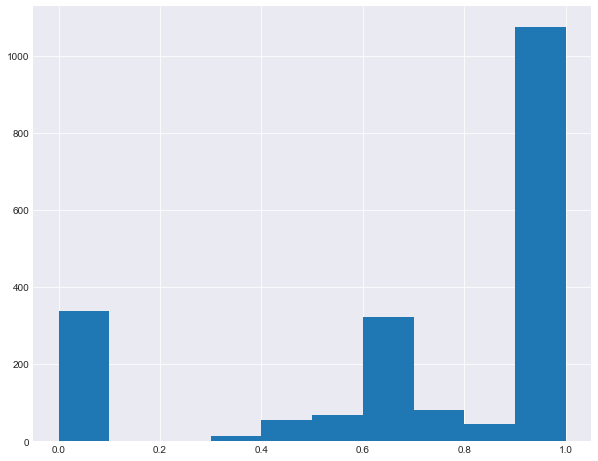

In [439]:
pdl_contact_all[['NAME_STD','data.full_name_STD']].fillna("").apply(lambda x: td.jaro_winkler.normalized_similarity(x['NAME_STD'],x["data.full_name_STD"]), axis = 1).hist()

In [440]:
pdl_contact_all["NAME_MATCH"] = pdl_contact_all[['NAME_STD','data.full_name_STD']].apply(lambda x: np.where(td.jaro_winkler.normalized_similarity(x['NAME_STD'],x["data.full_name_STD"])>= 0.85, True, False), axis = 1)
pdl_contact_all["NAME_MATCH_BINARY"] = np.where(pdl_contact_all["NAME_MATCH"] == True, 1,0)

## Mobile Phone Matching

In [441]:
def mobile_phone_match(row):
    if row["data.phone_numbers"] == "":
        return False
    elif row["MOBILE_PHONE_STD"] in ast.literal_eval(row["data.phone_numbers"]):
        return True
    else:
        return False


In [442]:
pdl_contact_all["MOBILE_PHONE_MATCH"] = pdl_contact_all[['MOBILE_PHONE_STD','data.phone_numbers']].fillna("").apply(mobile_phone_match, axis = 1)
pdl_contact_all["MOBILE_PHONE_MATCH_BINARY"] = np.where(pdl_contact_all["MOBILE_PHONE_MATCH"] == True, 1,0)

In [443]:
def pdl_mobile_phone_exist_match(row):
    if row["MOBILE_PHONE_STD"] == "" or row["data.mobile_phone_STD"] == "":
        return False
    elif row["MOBILE_PHONE_STD"] == row["data.mobile_phone_STD"]:
        return True
    else:
        return False


In [444]:
pdl_contact_all["PDL_MOBILE_PHONE_EXIST_MATCH"]= pdl_contact_all.apply(pdl_mobile_phone_exist_match, axis = 1)
pdl_contact_all["PDL_MOBILE_PHONE_EXIST_MATCH_BINARY"] = np.where(pdl_contact_all["PDL_MOBILE_PHONE_EXIST_MATCH"] == True, 1,0)

## Profile Matching

In [445]:
pdl_contact_all["PROFILE_MATCH"] = pdl_contact_all.apply(lambda row: np.where((row["EMAIL_MATCH"] == False )& (row["NAME_MATCH"] == False) & (row["MOBILE_PHONE_MATCH"]== False), False, True), axis = 1)

In [446]:
pdl_contact_all["PROFILE_MATCH_BINARY"] = np.where(pdl_contact_all["PROFILE_MATCH"] == True, 1,0)

# Profile Matching Results 

In [447]:
pdl_contact_all["PROFILE_MATCH"].value_counts()

True     1134
False     866
Name: PROFILE_MATCH, dtype: int64

In [448]:
# sanity check of matching

In [449]:
matching_col = ["likelihood",'matched',"NAME",'data.full_name',
                "EMAIL",'data.work_email',"data.personal_emails","data.emails_STD",
                "PHONE_STD","MOBILE_PHONE_STD",'data.mobile_phone_STD',"data.phone_numbers",
                "COMPANY","data.job_company_name","data.experience",
                "CITY",'data.job_company_location_locality',
                "STATE", "data.job_company_location_region"
                ]

In [450]:
pdl_contact_all[pdl_contact_all["PROFILE_MATCH"] == True][matching_col].sample(n = 20, random_state= 3)

,likelihood,matched,NAME,data.full_name,EMAIL,data.work_email,data.personal_emails,data.emails_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.phone_numbers,COMPANY,data.job_company_name,data.experience,CITY,data.job_company_location_locality,STATE,data.job_company_location_region
1935,10.0,"['phone', 'name']",kristi wright,kristi wright,NaN,NaN,['kristijwright@comcast.net'],['kristijwright@comcast.net'],+18322261399,,+18322261399,"['+12814860518', '+18322261399', '+12815546485...",Kristi Wright,NaN,[],League City,NaN,TX,NaN
1531,9.0,"['company', 'name']",branden cobb,branden cobb,NaN,NaN,['bcobbpersonal@gmail.com'],"['bcobbpersonal@gmail.com', 'branden.cobb@utol...",+18587554663,,+13106225511,['+13106225511'],Coastal Premier Properties,NaN,"[{'company': None, 'start_date': None, 'end_da...",San Diego,NaN,CA,NaN
849,10.0,"['email', 'company', 'name']",susan custer,susan custer,susan@newconnectionhomes.com,NaN,['susancuster@rocketmail.com'],['susancuster@rocketmail.com'],+18884212531,,,[],eXp Realty,exp realty,"[{'company': {'name': 'keller williams realty,...",Spokane,bellingham,WA,washington
549,10.0,"['email', 'name']",lynda granger,lynda granger,yourresidentialspecialist@gmail.com,NaN,['yourresidentialspecialist@gmail.com'],['yourresidentialspecialist@gmail.com'],+18057016988,,,[],eXp Realty of California Inc,NaN,[],Ventura,NaN,CA,NaN
412,10.0,"['email', 'name']",amanda gail seidel,amanda seidel,househunteramanda@gmail.com,NaN,['househunteramanda@gmail.com'],['househunteramanda@gmail.com'],+17138858781,+17138858781,,[],Amanda Gail Seidel,NaN,[],Humble,NaN,TX,NaN
450,9.0,"['company', 'name']",steve vaneman,steve vaneman,stevevaneman@realtyaustin.com,NaN,[],,+15128065650,+15129239159,,[],Lisa Hughes Gonzales,realty austin,"[{'company': {'name': 'living spree realty', '...",Austin,austin,TX,texas
518,10.0,"['email', 'name']",paul wirth,paul wirth,paul@jcap.net,NaN,[],['paul@jcap.net'],+19494293700,,,[],Avid Mortgage Solutions,NaN,"[{'company': {'name': 'jcap private lending', ...",San Clemente,NaN,CA,NaN
335,10.0,"['email', 'name']",michelle kay valenzuela,michelle valenzuela,mvalenzuela@westusa.com,NaN,[],['mvalenzuela@westusa.com'],+14808930600,+14809800248,,[],West Usa Realty,NaN,[{'company': {'name': 'the recon group- west u...,Phoenix,NaN,AZ,NaN
283,10.0,"['email', 'name']",renee rita epple,renee epple,renee@trurealty.com,NaN,[],['renee@trurealty.com'],+14803276700,+14808810670,,[],Tru Realty,NaN,[{'company': {'name': 'tru realty a phoenix re...,Scottsdale,NaN,AZ,NaN
555,10.0,"['company', 'name']",anita mccullough,anita mccullough,anita.realty@yahoo.com,NaN,['mcculloughanita@aol.com'],['mcculloughanita@aol.com'],+14089127670,,,[],Equity One Real Estate,"equity one real estate, inc.","[{'company': {'name': 'equity one real estate,...",San Jose,NaN,CA,NaN


In [451]:
pdl_contact_all[(pdl_contact_all["PROFILE_MATCH"] == False) & (pdl_contact_all["status"] == 200)][matching_col].sort_values("likelihood", ascending= False)

,likelihood,matched,NAME,data.full_name,EMAIL,data.work_email,data.personal_emails,data.emails_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.phone_numbers,COMPANY,data.job_company_name,data.experience,CITY,data.job_company_location_locality,STATE,data.job_company_location_region
1793,8.0,"['company', 'name']",rebecca l keenan,becky keenan,NaN,NaN,[],,+16022307600,,+16028268622,"['+16028268622', '+16022186283', '+16029561305...",Homesmart,NaN,"[{'company': {'name': 'homesmart', 'size': Non...",Phoenix,NaN,AZ,NaN
588,8.0,"['phone', 'last_name']",david alaei,mehran alaei,david@hoamc.com,NaN,"['dashizzle5@yahoo.com', 'mehran.alaei@gmail.c...","['dashizzle5@yahoo.com', 'mehran.alaei@gmail.c...",+18582021654,,,"['+12516657342', '+18582021654', '+12516338442']",Alaei Realty,NaN,"[{'company': None, 'location_names': [], 'end_...",San Diego,NaN,CA,NaN
785,8.0,"['email', 'last_name']",hai huynh,jason huynh,jasonhuynh@kw.com,NaN,[],,+12815997600,,+12819195685,['+12819195685'],"Joe Rothchild Realty Two, LLC",NaN,[{'company': {'name': 'jason hai huynh keller ...,Katy,NaN,TX,NaN
1868,8.0,"['phone', 'last_name']",larry k cheuk,mei cheuk,NaN,NaN,[],,+16022918819,,,['+16022918819'],GOLD COAST REALTY,NaN,[],CHANDLER,NaN,AZ,NaN
1588,8.0,"['phone', 'last_name']",david alaei,mehran alaei,NaN,NaN,"['dashizzle5@yahoo.com', 'mehran.alaei@gmail.c...","['dashizzle5@yahoo.com', 'mehran.alaei@gmail.c...",+18582021654,,,"['+12516657342', '+18582021654', '+12516338442']",Alaei Realty,NaN,"[{'company': None, 'location_names': [], 'end_...",San Diego,NaN,CA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1849,0.0,['phone'],adriana cabrera,michael krever,NaN,NaN,['michael.krever@bellsouth.net'],['michael.krever@bellsouth.net'],+16235371515,,,"['+16236943305', '+16232148706', '+16239757047...",COLDWELL BANKER REALTY,NaN,[],SURPRISE,NaN,AZ,NaN
944,0.0,['phone'],adriana cabrera,michael krever,adrianaazrealty@gmail.com,NaN,[],,+16235371515,,,"['+16232141487', '+16236943305', '+16232148706...",COLDWELL BANKER REALTY,NaN,[],SURPRISE,NaN,AZ,NaN
711,0.0,['phone'],britany lashawn freeman,ashley campbell,britanyfreemanre@gmail.com,NaN,[],['info@remaxgeneration.com'],+18328506447,,,['+18328506447'],Generation Unlimited LLC,NaN,[],Humble,NaN,TX,NaN
1680,0.0,['phone'],thomas cordell,chris crenshaw,NaN,NaN,"['balfe@msn.com', 'akashicmoon@netscape.net']","['balfe@msn.com', 'balfe@olc-architects.com', ...",+12538457275,,,"['+12039343492', '+12538457275']",Park Place Properties,NaN,"[{'company': {'name': 'y.u.d.i.p', 'size': Non...",Federal Way,NaN,WA,NaN


In [452]:
# for all those retrieved data with all params, only 1 of them are not matched manually
pdl_contact_all.query("LABEL == 'ALL' & status == 200")["PROFILE_MATCH"].value_counts()

True     344
False      1
Name: PROFILE_MATCH, dtype: int64

In [453]:
# it seems that the unmatched one is actually match
pdl_contact_all.query("LABEL == 'ALL' & status == 200 & PROFILE_MATCH == False")[matching_col]

,likelihood,matched,NAME,data.full_name,EMAIL,data.work_email,data.personal_emails,data.emails_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.phone_numbers,COMPANY,data.job_company_name,data.experience,CITY,data.job_company_location_locality,STATE,data.job_company_location_region
338,3.0,"['company', 'name']",a john bayo,john bayo,ajohnbayo@gmail.com,NaN,[],,+14808930600,+14807397791,+14804168502,['+14804168502'],West Usa Realty,west usa realty,"[{'company': {'name': 'excel industries llc', ...",Phoenix,phoenix,AZ,arizona


In [454]:
pdl_contact_all.query("LABEL == 'ALL' & PROFILE_MATCH == False")[matching_col].sample(n =20, random_state=1)

,likelihood,matched,NAME,data.full_name,EMAIL,data.work_email,data.personal_emails,data.emails_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.phone_numbers,COMPANY,data.job_company_name,data.experience,CITY,data.job_company_location_locality,STATE,data.job_company_location_region
398,NaN,NaN,vienna julien,NaN,viennajulien@kw.com,NaN,NaN,,+12813350335,+18324052355,,NaN,"Keller Williams Clear Lake NASA, Houston",NaN,NaN,Houston,NaN,TX,NaN
264,NaN,NaN,wesley s evans,NaN,e_wes@hotmail.com,NaN,NaN,,+16232429459,+14802212109,,NaN,MY HOME GROUP,NaN,NaN,Scottsdale,NaN,AZ,NaN
187,NaN,NaN,saviya robinson,NaN,saviya@kw.com,NaN,NaN,,+12066322636,+12063348348,,NaN,Keller Williams Greater Sea,NaN,NaN,Seattle,NaN,WA,NaN
115,NaN,NaN,kylie cardenas,NaN,kylie@hitchcockre.com,NaN,NaN,,+18052840881,+18054023969,,NaN,Compass,NaN,NaN,Santa Barbara,NaN,CA,NaN
126,NaN,NaN,mia bowman,NaN,admin@goteamred.com,NaN,NaN,,+12538354500,+12536702289,,NaN,Keller Williams Realty PS,NaN,NaN,Federal Way,NaN,WA,NaN
140,NaN,NaN,katelyn kirkham,NaN,kateykirkham@gmail.com,NaN,NaN,,+14254826100,+14254780090,,NaN,Keller Williams Realty Bothell,NaN,NaN,Bothell,NaN,WA,NaN
57,NaN,NaN,christine morton,NaN,christine.morton@camoves.com,NaN,NaN,,+16265840050,+16262227093,,NaN,Coldwell Banker,NaN,NaN,PASADENA,NaN,CA,NaN
381,NaN,NaN,tia brooks,NaN,tia1@kw.com,NaN,NaN,,+12813350335,+14095399375,,NaN,"Keller Williams Clear Lake NASA, Houston",NaN,NaN,Houston,NaN,TX,NaN
198,NaN,NaN,jacob pickett,NaN,jacob@russelljonesrealestate.com,NaN,NaN,,+12063230800,+12064597048,,NaN,Russell Jones Real Estate,NaN,NaN,Seattle,NaN,WA,NaN
475,NaN,NaN,frank baker,NaN,frankbakerrealty@gmail.com,NaN,NaN,,+12147835442,+14694944807,,NaN,Andrew J Mcanally,NaN,NaN,Celina,NaN,TX,NaN


In [455]:
pdl_contact_all[pdl_contact_all["status"] == 200].astype(str).groupby("LABEL")["PROFILE_MATCH"].value_counts().to_frame('count')

count
LABEL          PROFILE_MATCH       
ALL            True             344
               False              1
NO_EMAIL       True             223
               False              2
NO_EMAIL_PHONE True             229
               False            107
NO_PHONE       True             338
               False             72

In [456]:
pdl_contact_all[pdl_contact_all["status"] == 200].groupby("LABEL")["PROFILE_MATCH_BINARY"].mean().to_frame('profile_match_hit_rate')

,profile_match_hit_rate
LABEL,
ALL,0.997101
NO_EMAIL,0.991111
NO_EMAIL_PHONE,0.681548
NO_PHONE,0.824390


In [457]:
# pdl_contact_all.query("LABEL == 'NO_EMAIL_PHONE' & status == 200 & PROFILE_MATCH == False")['matched'].value_counts()

In [458]:
# non mobile phone matching is insufficient
pdl_contact_all[(pdl_contact_all["LABEL"] == 'NO_EMAIL_PHONE') & (pdl_contact_all['status'] == 200) &(pdl_contact_all['matched'] == "['phone']")]['PROFILE_MATCH'].value_counts()

False    69
Name: PROFILE_MATCH, dtype: int64

In [459]:
pdl_contact_all["LABEL"].unique()

array(['ALL', 'NO_PHONE', 'NO_EMAIL', 'NO_EMAIL_PHONE'], dtype=object)

In [460]:
pdl_contact_all.groupby('matched')[["MOBILE_PHONE_MATCH","PDL_MOBILE_PHONE_EXIST_MATCH"]].value_counts().to_frame()

0
matched                               MOBILE_PHONE_MATCH PDL_MOBILE_PHONE_EXIST_MATCH     
['company', 'name']                   False              False                         513
                                      True               True                           90
                                                         False                           6
['email', 'company', 'last_name']     False              False                           1
                                      True               True                            1
['email', 'company', 'name']          False              False                          88
                                      True               True                           19
                                                         False                           4
['email', 'company']                  False              False                           6
['email', 'first_name']               False              False                           3
                                      True               False                           1
['email', 'last_name']                False              False                           5
                                      True               True                            3
                                                         False                           1
['email', 'name']                     False              False                         237
                                      True               True                           20
                                                         False                           7
['email', 'phone', 'company', 'name'] False              False                           5
['email', 'phone', 'name']            False              False                           6
['email']                             False              False                           6
['name']                              False              False                          51
                                      True               True                           12
['phone', 'company', 'name']          False              False                          20
['phone', 'company']                  False              False                          59
['phone', 'first_name']               False              False                           2
['phone', 'last_name']                False              False                           3
['phone', 'name']                     False              False                          36
['phone']                             False              False                         111

In [461]:
pdl_contact_all.query("LABEL == 'ALL'")[["MOBILE_PHONE_MATCH","PDL_MOBILE_PHONE_EXIST_MATCH"]].value_counts().to_frame()

0
MOBILE_PHONE_MATCH PDL_MOBILE_PHONE_EXIST_MATCH     
False              False                         410
True               True                           76
                   False                          14

In [462]:
pdl_contact_all[(pdl_contact_all["LABEL"] == "ALL")& (pdl_contact_all["MOBILE_PHONE_MATCH"] == False)]["data.mobile_phone"].notna().sum() 

10

In [463]:
# other to consider

In [464]:
# 0 likelihood
pdl_contact_all[pdl_contact_all["likelihood"]== 0]

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY
711,britany lashawn freeman,britanyfreemanre@gmail.com,(832) 850-6447,NaN,Generation Unlimited LLC,Humble,TX,200,NaN,NaN,0.0,['phone'],18.1,qFEk66SR3GQkzb3PrlWX2w_0000,ashley campbell,ashley,NaN,NaN,c,campbell,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"denver, colorado, united states",denver,"denver, colorado",colorado,united states,north america,NaN,NaN,NaN,"39.73,-104.98",NaN,['+18328506447'],"[{'address': 'info@remaxgeneration.com', 'type...",[],[],"['denver, colorado, united states']","['colorado, united states']",['united states'],[],[],[],[],NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'COMPANY', 'CITY', ...",NO_PHONE,britany freeman,ashley campbell,+18328506447,,,['info@remaxgeneration.com'],False,0,False,0,False,0,False,0,False,0
875,thomas cordell,thomascordellre@gmail.com,2538457275,NaN,Park Place Properties,Federal Way,WA,200,NaN,NaN,0.0,['phone'],18.1,DBZ0iw59N89J581U7MIBYg_0000,chris crenshaw,chris,NaN,NaN,c,crenshaw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['balfe@msn.com', 'akashicmoon@netscape.net']",NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"puyallup, washington, united states",puyallup,"seattle, washington",washington,united states,north america,13212 98th avenue court east,apartment d,98373.0,"47.18,-122.29",NaN,"['+12039343492', '+12538457275']","[{'address': 'balfe@msn.com', 'type': 'persona...",[],[],"['puyallup, washington, united states']","['washington, united states']",['united states'],"[{'name': 'puyallup, washington, united states...","[{'company': {'name': 'y.u.d.i.p', 'size': Non...",[],[],NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'COMPANY', 'CITY', ...",NO_PHONE,thomas cordell,chris cr

In [465]:
pdl_contact_all[pdl_contact_all["LABEL"] == "ALL"][glimpse_col].tail(1).values

array([["['name']", 'cheryl nicole castillo', 'cheryl castillo',
        'cheryl@houseguiderealty.com', nan,
        "['dream2b2003@blackplanet.com', 'dream2b2003@aol.com']",
        "[{'address': 'dream2b2003@blackplanet.com', 'type': 'personal'}, {'address': 'dream2b2003@aol.com', 'type': 'personal'}]",
        '(832) 421-4662', '(832) 421-4662', 18324214662.0,
        "['+18322989323', '+19792031884', '+18326889621', '+18323057685', '+19795519300', '+19795513788', '+12814695893', '+12818568796', '+17136882531', '+17138612549', '+19792517103', '+19792519045', '+19798269598', '+16786913691', '+17704135594', '+12818590000', '+17132259700', '+18174572079', '+17136839687', '+17138689633', '+18324214662']",
        'Cheryl Nicole Castillo', nan, '[]', 'Houston', nan, 'TX', nan]],
      dtype=object)

In [466]:
pdl_contact_all['data.id'].nunique()

500

In [467]:
pdl_contact_all.query("status == 200").groupby("LABEL")["data.id"].nunique()

LABEL
ALL               345
NO_EMAIL          225
NO_EMAIL_PHONE    307
NO_PHONE          391
Name: data.id, dtype: int64

In [468]:
pdl_contact_all.query("status == 200")["LABEL"].value_counts()

NO_PHONE          410
ALL               345
NO_EMAIL_PHONE    336
NO_EMAIL          225
Name: LABEL, dtype: int64

In [469]:
# multiple profiles refer to same person
pdl_contact_all.query("status == 200").groupby('NAME')['data.id'].nunique().sort_values(ascending= False).head(20)

NAME
barbara ann borchers           3
steven a mckamey               3
gene d hastings                2
robbie sikora                  2
rickey edward chavez           2
donna lea harris               2
ed cox                         2
elaine m barkl                 2
richard joseph avery           2
ellisa greer                   2
emily christine russell        2
renee rita epple               2
emo rowe                       2
rebecca l keenan               2
phyllis kirven johnson         2
eustorgio villa                2
fernando valle                 2
frank jurado                   2
frederick nathaniel moulton    2
kimberly a hodges              2
Name: data.id, dtype: int64

In [470]:
pdl_contact_all.query("status == 200").groupby('NAME')['data.id'].nunique().value_counts()

1    293
2    115
3      2
Name: data.id, dtype: int64

In [471]:
pdl_contact_all[pdl_contact_all["NAME"] == "barbara ann borchers"]

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY
483,barbara ann borchers,barbaraborchers@aol.com,(713) 515-2125,(713) 515-2125,Barbara Ann Borchers,Houston,TX,200,NaN,NaN,10.0,"['email', 'name']",18.1,lUAU7zak6smBd4lISrmFmw_0000,barbara borchers,barbara,NaN,NaN,b,borchers,female,NaN,NaN,linkedin.com/in/barbara-borchers-61a8bb14,barbara-borchers-61a8bb14,50014390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['barbaraborchers@aol.com'],NaN,real estate,real estate broker and associate,finance,NaN,[],walzel-properties-llc,"walzel properties, llc",walzelproperties.com,1-10,NaN,real estate,linkedin.com/company/walzel-properties-llc,16058252.0,NaN,NaN,"houston, texas, united states",houston,"houston, texas",texas,"29.76,-95.36",15420 ridge park drive,NaN,77095.0,united states,north america,2022-04-09,2019-07,"houston, texas, united states",houston,"houston, texas",texas,united states,north america,NaN,NaN,NaN,"29.76,-95.36",2022-04-09,[],"[{'address': 'barbaraborchers@aol.com', 'type'...",[],"['sellers', 'buyers', 'relocation', 'first tim...","['houston, texas, united states', 'connellsvil...","['pennsylvania, united states', 'south carolin...",['united states'],"[{'name': 'connellsville, pennsylvania, united...","[{'company': {'name': 'jerry reding', 'size': ...","[{'school': {'name': 'university of houston', ...","[{'network': 'linkedin', 'id': '50014390', 'ur...",NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'MOBILE_PHONE', 'CO...",ALL,barbara borchers,barbara borchers,+17135152125,+17135152125,,"['barbaraborchers@aol.com', 'sales@barbaraborc...",True,1,True,1,False,0,False,0,True,1
778,barbara ann borchers,barbaraborchers@aol.com,(713) 515-2125,NaN,Barbara Ann Borchers,Houston,TX,200,NaN,NaN,10.0,"['phone', 'name']",18.1,cXLAVw4FopTjsxFX89NLug_0000,barbara borchers,barbara,NaN,NaN,b,borchers,female,1954.0,NaN,NaN,NaN,NaN,facebook.com/barbara.borchers.71,barbara.borchers.71,1.477374e+09,NaN,N

In [472]:
pdl_contact_all[pdl_contact_all["NAME"].isin(pdl_contact_all.query("status == 200").groupby('NAME')['data.id'].nunique().sort_values(ascending= False).head(10).index)].sort_values('NAME').head(10)

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY
1983,barbara ann borchers,NaN,(713) 515-2125,NaN,Barbara Ann Borchers,Houston,TX,200,NaN,NaN,10.0,"['phone', 'name']",18.1,cXLAVw4FopTjsxFX89NLug_0000,barbara borchers,barbara,NaN,NaN,b,borchers,female,1954.0,NaN,NaN,NaN,NaN,facebook.com/barbara.borchers.71,barbara.borchers.71,1.477374e+09,NaN,NaN,NaN,NaN,NaN,"['barbaraborchers@juno.com', 'mattborchers@aol...",1.713515e+10,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"houston, texas, united states",houston,"houston, texas",texas,united states,north america,6515 coral ridge road,NaN,77069.0,"29.76,-95.36",2021-07-01,"['+12817818356', '+17135152125', '+17138938036...","[{'address': 'barbaraborchers@juno.com', 'type...",[],[],"['houston, texas, united states']","['texas, united states']",['united states'],"[{'name': 'houston, texas, united states', 'lo...",[],[],"[{'network': 'facebook', 'id': '1477373526', '...",NaN,[],NaN,NaN,"['NAME', 'PHONE', 'COMPANY', 'CITY', 'STATE']",NO_EMAIL_PHONE,barbara borchers,barbara borchers,+17135152125,,+17135152125,"['barbaraborchers@juno.com', 'mattborchers@aol...",False,0,True,1,False,0,False,0,True,1
1483,barbara ann borchers,NaN,(713) 515-2125,(713) 515-2125,Barbara Ann Borchers,Houston,TX,200,NaN,NaN,4.0,['name'],18.1,WWumvxMsObPecdAft9knJg_0000,barbara borchers,barbara,a,ann,b,borchers,female,1954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"vandalia, ohio, united states",vandalia,"dayton, ohio",ohio,united states,north america,402 randler avenue,NaN,45377.0,"39.89,-84.19",2021-07-01,"['+14199537433', '+14196293809', '+19375068866...",[],[],[],"['tipp city, ohio, united states', 'vandalia, ...","['ohio, united states']",['united states'],"[{'name': 'vandalia, oh

## match rate analyses

In [473]:
pdl_contact_all.query("status == 200").groupby('matched').agg({'likelihood':['mean','median','count']}).sort_values(by = [('likelihood','mean'),],ascending= False)

likelihood             
                                            mean median count
matched                                                      
['phone', 'company', 'name']           10.000000   10.0    20
['email', 'phone', 'company', 'name']  10.000000   10.0     5
['email', 'company', 'name']            9.963964   10.0   111
['email', 'name']                       9.840909   10.0   264
['phone', 'name']                       9.805556   10.0    36
['email', 'phone', 'name']              9.666667   10.0     6
['company', 'name']                     8.215107    9.0   609
['phone', 'last_name']                  8.000000    8.0     3
['email', 'company']                    8.000000    8.0     6
['email', 'last_name']                  7.444444    8.0     9
['email', 'company', 'last_name']       7.000000    7.0     2
['phone', 'first_name']                 7.000000    7.0     2
['email', 'first_name']                 6.500000    6.5     4
['phone', 'company']                    5.779661    6.0    59
['name']                                3.476190    3.0    63
['phone']                               2.738739    4.0   111
['email']                               2.666667    2.0     6

In [474]:
# top combinations
# avoid: ['phone', 'company'], ['phone', 'last_name'], ['phone'] combinations
pdl_contact_all.query("status == 200").groupby('matched').agg({'NAME_MATCH_BINARY':['mean'],'EMAIL_MATCH_BINARY':['mean'],'MOBILE_PHONE_MATCH_BINARY':['mean'],'PROFILE_MATCH_BINARY':['mean'],'matched':['count']}).sort_values(by = [('PROFILE_MATCH_BINARY','mean')],ascending= False)

,NAME_MATCH_BINARY,EMAIL_MATCH_BINARY,MOBILE_PHONE_MATCH_BINARY,PROFILE_MATCH_BINARY,matched
,mean,mean,mean,mean,count
matched,,,,,
"['email', 'phone', 'name']",1.000000,1.000000,0.000000,1.000000,6
"['phone', 'company', 'name']",1.000000,0.000000,0.000000,1.000000,20
"['email', 'company', 'name']",0.981982,0.819820,0.207207,1.000000,111
"['email', 'company']",0.666667,1.000000,0.000000,1.000000,6
"['email', 'first_name']",0.500000,1.000000,0.250000,1.000000,4
"['phone', 'name']",1.000000,0.000000,0.000000,1.000000,36
"['email', 'name']",1.000000,0.946970,0.102273,1.000000,264
"['email', 'phone', 'company', 'name']",1.000000,0.800000,0.000000,1.000000,5


In [475]:
pdl_contact_all.query("status == 200").groupby("LABEL").agg({"NAME_MATCH_BINARY":'mean',"EMAIL_MATCH_BINARY":'mean',"MOBILE_PHONE_MATCH_BINARY":'mean',"PROFILE_MATCH_BINARY":'mean'})

,NAME_MATCH_BINARY,EMAIL_MATCH_BINARY,MOBILE_PHONE_MATCH_BINARY,PROFILE_MATCH_BINARY
LABEL,,,,
ALL,0.965217,0.550725,0.260870,0.997101
NO_EMAIL,0.986667,0.000000,0.328889,0.991111
NO_EMAIL_PHONE,0.681548,0.000000,0.000000,0.681548
NO_PHONE,0.804878,0.448780,0.000000,0.824390


In [476]:
pdl_contact_all.astype(str).groupby("LABEL")[["NAME_MATCH","MOBILE_PHONE_MATCH","EMAIL_MATCH"]].value_counts(normalize = True).to_frame('count')

count
LABEL          NAME_MATCH MOBILE_PHONE_MATCH EMAIL_MATCH       
ALL            False      False              False        0.312
               True       False              True         0.276
                                             False        0.220
                          True               True         0.086
                                             False        0.084
               False      False              True         0.012
                          True               True         0.006
                                             False        0.004
NO_EMAIL       False      False              False        0.554
               True       False              False        0.298
                          True               False        0.146
               False      True               False        0.002
NO_EMAIL_PHONE False      False              False        0.542
               True       False              False        0.458
NO_PHONE       True       False              True         0.352
               False      False              False        0.324
               True       False              False        0.308
               False      False              True         0.016

In [477]:
# pdl_contact_all[pdl_contact_all["LABEL"] == "NO_EMAIL"].sample(n = 20)

In [478]:
# likelihood of 7 is a good threshold
pdl_contact_all.query("status == 200").groupby('likelihood').agg({'NAME_MATCH_BINARY':['mean'],'EMAIL_MATCH_BINARY':['mean'],'MOBILE_PHONE_MATCH_BINARY':['mean'],'PROFILE_MATCH_BINARY':['mean'],'likelihood':['count']}).sort_index(ascending= False)

,NAME_MATCH_BINARY,EMAIL_MATCH_BINARY,MOBILE_PHONE_MATCH_BINARY,PROFILE_MATCH_BINARY,likelihood
,mean,mean,mean,mean,count
likelihood,,,,,
10.0,1.000000,0.687104,0.120507,1.000000,473
9.0,1.000000,0.016997,0.161473,1.000000,353
8.0,0.863636,0.272727,0.163636,0.954545,110
7.0,0.857143,0.061224,0.204082,0.938776,49
6.0,0.560000,0.040000,0.040000,0.560000,100
5.0,0.548387,0.064516,0.161290,0.612903,31
4.0,0.340659,0.000000,0.054945,0.340659,91
3.0,0.542857,0.000000,0.057143,0.542857,35


In [479]:
pdl_contact_all.query("status == 200 & LABEL == 'NO_EMAIL'").groupby('likelihood').agg({'NAME_MATCH_BINARY':['mean'],'EMAIL_MATCH_BINARY':['mean'],'MOBILE_PHONE_MATCH_BINARY':['mean'],'PROFILE_MATCH_BINARY':['mean'],'likelihood':['count']}).sort_index(ascending= False)

,NAME_MATCH_BINARY,EMAIL_MATCH_BINARY,MOBILE_PHONE_MATCH_BINARY,PROFILE_MATCH_BINARY,likelihood
,mean,mean,mean,mean,count
likelihood,,,,,
10.0,1.000000,0.0,0.291667,1.000000,24
9.0,1.000000,0.0,0.348624,1.000000,109
8.0,0.960000,0.0,0.400000,1.000000,25
7.0,1.000000,0.0,0.357143,1.000000,14
6.0,1.000000,0.0,0.142857,1.000000,14
5.0,1.000000,0.0,0.666667,1.000000,6
4.0,1.000000,0.0,0.250000,1.000000,12
3.0,0.888889,0.0,0.222222,0.888889,9


In [480]:
pdl_contact_all.query("status == 200 & LABEL == 'NO_PHONE'").groupby('likelihood').agg({'NAME_MATCH_BINARY':['mean'],'EMAIL_MATCH_BINARY':['mean'],'MOBILE_PHONE_MATCH_BINARY':['mean'],'PROFILE_MATCH_BINARY':['mean'],'likelihood':['count']}).sort_index(ascending= False)

,NAME_MATCH_BINARY,EMAIL_MATCH_BINARY,MOBILE_PHONE_MATCH_BINARY,PROFILE_MATCH_BINARY,likelihood
,mean,mean,mean,mean,count
likelihood,,,,,
10.0,1.000000,0.776699,0.0,1.000000,206
9.0,1.000000,0.044118,0.0,1.000000,68
8.0,0.793103,0.517241,0.0,0.931034,29
7.0,0.700000,0.100000,0.0,0.800000,10
6.0,0.411765,0.058824,0.0,0.411765,34
5.0,0.375000,0.125000,0.0,0.500000,8
4.0,0.142857,0.000000,0.0,0.142857,28
3.0,0.285714,0.000000,0.0,0.285714,7


In [481]:
# in NO_EMAIL_PHONE case, likelihood of 7 still works
pdl_contact_all.query("status == 200 & LABEL == 'NO_EMAIL_PHONE'").groupby('likelihood').agg({'NAME_MATCH_BINARY':['mean'],'EMAIL_MATCH_BINARY':['mean'],'MOBILE_PHONE_MATCH_BINARY':['mean'],'PROFILE_MATCH_BINARY':['mean'],'likelihood':['count']}).sort_index(ascending= False)

,NAME_MATCH_BINARY,EMAIL_MATCH_BINARY,MOBILE_PHONE_MATCH_BINARY,PROFILE_MATCH_BINARY,likelihood
,mean,mean,mean,mean,count
likelihood,,,,,
10.0,1.000000,0.0,0.0,1.000000,49
9.0,1.000000,0.0,0.0,1.000000,103
8.0,0.892857,0.0,0.0,0.892857,28
7.0,0.937500,0.0,0.0,0.937500,16
6.0,0.368421,0.0,0.0,0.368421,38
5.0,0.384615,0.0,0.0,0.384615,13
4.0,0.162791,0.0,0.0,0.162791,43
3.0,0.400000,0.0,0.0,0.400000,15


In [482]:
# using company name, email, and name, and setting min_likelihood == 7
# not enough information for a person with different pdl_id profiles and their data qualities

## BD team analyses

In [483]:
# For those Contacts included in our study with City = 'San Francisco'
# How many of contacts did we include in the study, out of the 500?

In [484]:
pdl_contact_all[pdl_contact_all["data.job_company_location_locality"] == "san francisco"]["NAME"].nunique()

4

In [485]:
# 8 contacts are included
pdl_contact_all[pdl_contact_all["CITY"] == "San Francisco"]["NAME"].nunique()

8

In [486]:
# How many had a mobile phone returned (when using the NO_PHONE label)

In [487]:
# 2 of them has a mobile phone return
pdl_contact_all[(pdl_contact_all["CITY"] == "San Francisco") & (pdl_contact_all["LABEL"]== "NO_PHONE")]["data.mobile_phone"].notna().sum()

2

In [488]:
# For those where a mobile phone was returned, what was the match rate with what we had on file?

In [489]:
pdl_contact_all[(pdl_contact_all["CITY"] == "San Francisco") & (pdl_contact_all["LABEL"]== "NO_PHONE") & (pdl_contact_all["data.mobile_phone"].notna())][["MOBILE_PHONE","data.mobile_phone"]]

,MOBILE_PHONE,data.mobile_phone
514,NaN,1.415706e+10
566,NaN,1.310591e+10


In [490]:
# the match rate of mobile phone on file is 50%
name_np_mp = pdl_contact_all[(pdl_contact_all["CITY"] == "San Francisco") & (pdl_contact_all["LABEL"]== "NO_PHONE") & (pdl_contact_all["data.mobile_phone"].notna())]["NAME"]
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_np_mp))& (pdl_contact_all["LABEL"] == "ALL")])
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_np_mp))& (pdl_contact_all["LABEL"] == "ALL")][["MOBILE_PHONE_STD","data.mobile_phone_STD"]])

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY
14,colleen cotter,ccotter@vanguardsf.com,415-321-7000,(415) 706-1781,Vanguard Properties,San Francisco,CA,200,NaN,NaN,10.0,"['email', 'company', 'name']",18.1,DoXLwWe3MkCtPdJzGSN9hg_0000,colleen cotter,colleen,m,NaN,c,cotter,female,1979.0,1979-12,linkedin.com/in/colleen-cotter-7372152,colleen-cotter-7372152,6500059.0,facebook.com/colleen.m.cotter,colleen.m.cotter,728401539.0,NaN,NaN,NaN,NaN,NaN,['colleen.cotter@hotmail.com'],1.415706e+10,real estate,real estate consultant,real_estate,NaN,[],vanguard-properties,vanguard properties,vanguardproperties.com,201-500,1986.0,real estate,linkedin.com/company/vanguard-properties,27836.0,facebook.com/vanguardsf,NaN,"san francisco, california, united states",san francisco,"san francisco, california",california,"37.77,-122.41",2501 mission street,NaN,94110.0,united states,north america,2021-02-01,2007-07,"san francisco, california, united states",san francisco,"san francisco, california",california,united states,north america,11 haight street,apartment 3,94102.0,"37.77,-122.41",2021-03-01,['+14157061781'],"[{'address': 'ccotter@vanguardsf.com', 'type':...","['exercise', 'reading', 'gourmet cooking', 'he...","['real estate', 'commercial real estate', 'res...","['san francisco, california, united states']","['california, united states']",['united states'],"[{'name': 'san francisco, california, united s...","[{'company': {'name': 'vanguard properties', '...",[{'school': {'name': 'st. ignatius college pre...,"[{'network': 'linkedin', 'id': '6500059', 'url...",NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'MOBILE_PHONE', 'CO...",ALL,colleen cotter,colleen cotter,+14153217000,+14157061781,+14157061781,"['ccotter@vanguardsf.com', 'colleen.cotter@hot...",True,1,True,1,True,1,True,1,True,1
66,jack archie,jack@pacificplainsrealty.com,415-525-4913,619-618-5995,"Side, Inc.",San Francisco,CA,404,not_found,

,MOBILE_PHONE_STD,data.mobile_phone_STD
14,+14157061781,+14157061781
66,+16196185995,


In [491]:
display(pdl_contact_all[(pdl_contact_all["CITY"] == "San Francisco") & (pdl_contact_all["LABEL"]== "NO_PHONE") & (pdl_contact_all["data.mobile_phone"].notna())])
display(pdl_contact_all[(pdl_contact_all["CITY"] == "San Francisco") & (pdl_contact_all["LABEL"]== "NO_PHONE") & (pdl_contact_all["data.mobile_phone"].notna())][["MOBILE_PHONE_STD","data.mobile_phone_STD"]])

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY
514,colleen cotter,ccotter@vanguardsf.com,415-321-7000,NaN,Vanguard Properties,San Francisco,CA,200,NaN,NaN,10.0,"['email', 'company', 'name']",18.1,DoXLwWe3MkCtPdJzGSN9hg_0000,colleen cotter,colleen,m,NaN,c,cotter,female,1979.0,1979-12,linkedin.com/in/colleen-cotter-7372152,colleen-cotter-7372152,6500059.0,facebook.com/colleen.m.cotter,colleen.m.cotter,728401539.0,NaN,NaN,NaN,NaN,NaN,['colleen.cotter@hotmail.com'],1.415706e+10,real estate,real estate consultant,real_estate,NaN,[],vanguard-properties,vanguard properties,vanguardproperties.com,201-500,1986.0,real estate,linkedin.com/company/vanguard-properties,27836.0,facebook.com/vanguardsf,NaN,"san francisco, california, united states",san francisco,"san francisco, california",california,"37.77,-122.41",2501 mission street,NaN,94110.0,united states,north america,2021-02-01,2007-07,"san francisco, california, united states",san francisco,"san francisco, california",california,united states,north america,11 haight street,apartment 3,94102.0,"37.77,-122.41",2021-03-01,['+14157061781'],"[{'address': 'ccotter@vanguardsf.com', 'type':...","['exercise', 'reading', 'gourmet cooking', 'he...","['real estate', 'commercial real estate', 'res...","['san francisco, california, united states']","['california, united states']",['united states'],"[{'name': 'san francisco, california, united s...","[{'company': {'name': 'vanguard properties', '...",[{'school': {'name': 'st. ignatius college pre...,"[{'network': 'linkedin', 'id': '6500059', 'url...",NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'COMPANY', 'CITY', ...",NO_PHONE,colleen cotter,colleen cotter,+14153217000,,+14157061781,"['ccotter@vanguardsf.com', 'colleen.cotter@hot...",True,1,True,1,False,0,False,0,True,1
566,jack archie,jack@pacificplainsrealty.com,415-525-4913,NaN,"Side, Inc.",San Francisco,CA,200,NaN,NaN,6.0,"['phone', 'company']

,MOBILE_PHONE_STD,data.mobile_phone_STD
514,,+14157061781
566,,+13105914627


In [492]:
# How many had 1 or more emails returned (when using NO_EMAIL label)

In [493]:
# 3 of them has 1 or more email
pdl_contact_all[(pdl_contact_all["CITY"] == "San Francisco") & (pdl_contact_all["LABEL"]== "NO_EMAIL")]["data.emails_STD"].apply(lambda x: len(ast.literal_eval(x)) if x != "" else 0).gt(0).sum()

3

In [494]:
# For those that had at least one email returned, what was our match rate with what we had on file (i.e. did our email appear in their email list anywhere)

In [495]:
pdl_contact_all["data.emails_STD_COUNT"] = pdl_contact_all["data.emails_STD"].apply(lambda x: len(ast.literal_eval(x)) if x != "" else 0)

In [496]:
# all has a email match
name_ne_me = pdl_contact_all[(pdl_contact_all["CITY"] == "San Francisco") & (pdl_contact_all["LABEL"]== "NO_EMAIL") & (pdl_contact_all["data.emails_STD_COUNT"].gt(0) )]["NAME"]
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_ne_me))& (pdl_contact_all["LABEL"] == "ALL")])
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_ne_me))& (pdl_contact_all["LABEL"] == "ALL")][["EMAIL","data.emails_STD","EMAIL_MATCH"]])
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_ne_me))& (pdl_contact_all["LABEL"] == "ALL")]["EMAIL_MATCH"].sum())

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY,data.emails_STD_COUNT
14,colleen cotter,ccotter@vanguardsf.com,415-321-7000,(415) 706-1781,Vanguard Properties,San Francisco,CA,200,NaN,NaN,10.0,"['email', 'company', 'name']",18.1,DoXLwWe3MkCtPdJzGSN9hg_0000,colleen cotter,colleen,m,NaN,c,cotter,female,1979.0,1979-12,linkedin.com/in/colleen-cotter-7372152,colleen-cotter-7372152,6500059.0,facebook.com/colleen.m.cotter,colleen.m.cotter,728401539.0,NaN,NaN,NaN,NaN,NaN,['colleen.cotter@hotmail.com'],1.415706e+10,real estate,real estate consultant,real_estate,NaN,[],vanguard-properties,vanguard properties,vanguardproperties.com,201-500,1986.0,real estate,linkedin.com/company/vanguard-properties,27836.0,facebook.com/vanguardsf,NaN,"san francisco, california, united states",san francisco,"san francisco, california",california,"37.77,-122.41",2501 mission street,NaN,94110.0,united states,north america,2021-02-01,2007-07,"san francisco, california, united states",san francisco,"san francisco, california",california,united states,north america,11 haight street,apartment 3,94102.0,"37.77,-122.41",2021-03-01,['+14157061781'],"[{'address': 'ccotter@vanguardsf.com', 'type':...","['exercise', 'reading', 'gourmet cooking', 'he...","['real estate', 'commercial real estate', 'res...","['san francisco, california, united states']","['california, united states']",['united states'],"[{'name': 'san francisco, california, united s...","[{'company': {'name': 'vanguard properties', '...",[{'school': {'name': 'st. ignatius college pre...,"[{'network': 'linkedin', 'id': '6500059', 'url...",NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'MOBILE_PHONE', 'CO...",ALL,colleen cotter,colleen cotter,+14153217000,+14157061781,+14157061781,"['ccotter@vanguardsf.com', 'colleen.cotter@hot...",True,1,True,1,True,1,True,1,True,1,2
93,rose karta,rkarta@flyhomes.com,903-312-0306,(415) 231-7183,Flyhomes Inc.,San Francisco,

,EMAIL,data.emails_STD,EMAIL_MATCH
14,ccotter@vanguardsf.com,"['ccotter@vanguardsf.com', 'colleen.cotter@hot...",True
93,rkarta@flyhomes.com,['rkarta@flyhomes.com'],True
94,sorich@flyhomes.com,['sorich@flyhomes.com'],True


3

In [497]:
# For overall population (not just SF):
# How many had 1 or more emails returned (when using NO_EMAIL label)

In [498]:
# 132 out of 500 emails are returned
pdl_contact_all[(pdl_contact_all["LABEL"]== "NO_EMAIL")]["data.emails_STD"].apply(lambda x: len(ast.literal_eval(x)) if x != "" else 0).gt(0).sum()

132

In [499]:
# For those that had at least one email returned, what was our match rate with what we had on file (i.e. did our email appear in their email list anywhere)

In [500]:
#  the match rate is 50% 
name_ne_me_all = pdl_contact_all[(pdl_contact_all["LABEL"]== "NO_EMAIL") & (pdl_contact_all["data.emails_STD_COUNT"].gt(0) )]["NAME"]
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_ne_me_all))& (pdl_contact_all["LABEL"] == "ALL")][["EMAIL","data.emails_STD","EMAIL_MATCH"]].head())
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_ne_me_all))& (pdl_contact_all["LABEL"] == "ALL")]["EMAIL_MATCH"].sum())


,EMAIL,data.emails_STD,EMAIL_MATCH
14,ccotter@vanguardsf.com,"['ccotter@vanguardsf.com', 'colleen.cotter@hot...",True
16,jerry.bolin@dilbeck.com,['jerry.bolin@dilbeck.com'],True
17,fischer.lambert@nafinc.com,"['fischerlambert@bhhscal.com', 'fischerrl.07@g...",False
22,lauren@glassesfields.com,"['laurenglasses@gmail.com', 'lbiedenh@smu.edu'...",False
23,austin.vaccaro@compass.com,"['avaccaro@connectivity.com', 'austin.vaccaro@...",True


66

In [501]:
# How many had a mobile phone returned (when using the NO_PHONE label)

In [502]:
# 148 out of 500 of them has a mobile phone return
pdl_contact_all[(pdl_contact_all["LABEL"]== "NO_PHONE")]["data.mobile_phone"].notna().sum()

148

In [503]:
# For those where a mobile phone was returned, what was the match rate with what we had on file?

In [504]:
pdl_contact_all[(pdl_contact_all["LABEL"]== "NO_PHONE") & (pdl_contact_all["data.mobile_phone"].notna())][["MOBILE_PHONE","data.mobile_phone"]].head()

,MOBILE_PHONE,data.mobile_phone
506,NaN,1.626756e+10
514,NaN,1.415706e+10
515,NaN,1.714884e+10
522,NaN,1.562336e+10
523,NaN,1.310339e+10


In [505]:
# the match rate of mobile phone on file is 50%
name_np_mp_all = pdl_contact_all[(pdl_contact_all["LABEL"]== "NO_PHONE") & (pdl_contact_all["data.mobile_phone"].notna())]["NAME"]
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_np_mp_all))& (pdl_contact_all["LABEL"] == "ALL")].head())
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_np_mp_all))& (pdl_contact_all["LABEL"] == "ALL")][["MOBILE_PHONE_STD","data.mobile_phone_STD"]])
display(pdl_contact_all[(pdl_contact_all["NAME"].isin(name_np_mp_all))& (pdl_contact_all["LABEL"] == "ALL")]["PDL_MOBILE_PHONE_EXIST_MATCH"].sum())

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY,data.emails_STD_COUNT
6,jessie shih,lexxusjessie@yahoo.com,626-986-5344,(626) 755-5232,US National Realty,Rowland Heights,CA,200,NaN,NaN,10.0,"['email', 'name']",18.1,NM1Yv2Fwjs9Tuw1HEW-eyg_0000,jessie shih,jessie,c,NaN,s,shih,female,1963.0,NaN,NaN,NaN,NaN,facebook.com/jess.shin.7,jess.shin.7,1.000011e+14,NaN,NaN,NaN,NaN,NaN,['lexxusjessie@yahoo.com'],1.626756e+10,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"temple city, california, united states",temple city,"los angeles, california",california,united states,north america,5246 sereno drive,NaN,91780.0,"34.10,-118.05",2021-07-01,"['+16262915706', '+16267555232', '+16262853966...","[{'address': 'lexxusjessie@yahoo.com', 'type':...",[],[],"['alta loma, california, united states', 'ranc...","['california, united states', 'taiwan, taiwan']","['united states', 'taiwan']","[{'name': 'temple city, california, united sta...",[],[{'school': {'name': 'national chung hsing uni...,"[{'network': 'facebook', 'id': '10000108922926...",NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'MOBILE_PHONE', 'CO...",ALL,jessie shih,jessie shih,+16269865344,+16267555232,+16267555232,['lexxusjessie@yahoo.com'],True,1,True,1,True,1,True,1,True,1,1
14,colleen cotter,ccotter@vanguardsf.com,415-321-7000,(415) 706-1781,Vanguard Properties,San Francisco,CA,200,NaN,NaN,10.0,"['email', 'company', 'name']",18.1,DoXLwWe3MkCtPdJzGSN9hg_0000,colleen cotter,colleen,m,NaN,c,cotter,female,1979.0,1979-12,linkedin.com/in/colleen-cotter-7372152,colleen-cotter-7372152,6500059.0,facebook.com/colleen.m.cotter,colleen.m.cotter,7.284015e+08,NaN,NaN,NaN,NaN,NaN,['colleen.cotter@hotmail.com'],1.415706e+10,real estate,real estate consultant,real_estate,NaN,[],vanguard-properties,vanguard properties,vanguardproperties.com,201-500,1986.0,real estate,linkedin.com/company/vangu

,MOBILE_PHONE_STD,data.mobile_phone_STD
6,+16267555232,+16267555232
14,+14157061781,+14157061781
15,+17148837877,+17148837877
22,+15623358548,+15623358548
23,+13103391309,+13103391309
...,...,...
494,+18179396584,+18179396584
496,+12104807636,
497,+12814350873,
498,+17134708478,


76

In [506]:
# Can you export a CSV containing all of the distinct job_title values you saw returned across the entire population?

In [507]:
pdl_contact_all.head()

,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,likelihood,matched,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,SEARCH_SUBSET,LABEL,NAME_STD,data.full_name_STD,PHONE_STD,MOBILE_PHONE_STD,data.mobile_phone_STD,data.emails_STD,EMAIL_MATCH,EMAIL_MATCH_BINARY,NAME_MATCH,NAME_MATCH_BINARY,MOBILE_PHONE_MATCH,MOBILE_PHONE_MATCH_BINARY,PDL_MOBILE_PHONE_EXIST_MATCH,PDL_MOBILE_PHONE_EXIST_MATCH_BINARY,PROFILE_MATCH,PROFILE_MATCH_BINARY,data.emails_STD_COUNT
0,paige gordon,paige.gordon@corcorangroup.com,(818) 661-4661,(805) 750-2105,"The Address, Inc",Agoura Hills,CA,404,not_found,No records were found matching your request,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'MOBILE_PHONE', 'CO...",ALL,paige gordon,,+18186614661,+18057502105,,,False,0,False,0,False,0,False,0,False,0,0
1,tami jo simon,tamijo@addressrealestate.com,(818) 661-4661,(818) 687-5697,"The Address, Inc",Agoura Hills,CA,200,NaN,NaN,9.0,"['company', 'name']",18.1,qnecNhvfDCI0ZoqfVwUiaQ_0000,tami simon,tami,j,jo,s,simon,female,NaN,NaN,linkedin.com/in/tami-jo-simon-15aa9095,tami-jo-simon-15aa9095,340091350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,real estate,broker and owner,finance,NaN,['owner'],NaN,quality one realty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-03,NaN,"simi valley, california, united states",simi valley,"oxnard, california",california,united states,north america,979 poplar court,NaN,93065.0,"34.26,-118.78",2021-07-01,[],[],[],"['investment properties', 'first time home buy...","['thousand oaks, california, united states', '...","['california, united states']",['united states'],"[{'name': 'simi valley, california, united sta...","[{'company': {'name': 'quality one realty', 's...",[],"[{'network': 'linkedin', 'id': '340091350', 'u...",NaN,[],NaN,NaN,"['NAME', 'EMAIL', 'PHONE', 'MOBILE_PHONE', 'CO...",ALL,tami simon,tami simon,+18186614661,+18186875697,,,False,0,True,1,False,0,False,0,True,1,0
2,clark harding,clark@clarkharding.com,707-541-6120,(707) 227

In [508]:
job_title = pd.DataFrame(pdl_contact_all["data.job_title"].unique(), columns = ["job_title"]).loc[1:,:]

In [509]:
# job_title.to_csv("../data/job_title.csv")

## arrange and create spreadsheet

In [510]:
# using ALL label
# salesforce id,  all input features, match,  likelihood score, pdl feature

In [511]:
sample_contact = pd.read_csv("../data/four_states_sample_contact.csv",index_col = 0)

In [512]:
sample_contact.head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,ACCOUNT_ID,IS_PERSON_ACCOUNT,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,OTHER_STREET,OTHER_CITY,OTHER_STATE,OTHER_POSTAL_CODE,OTHER_COUNTRY,OTHER_LATITUDE,OTHER_LONGITUDE,OTHER_GEOCODE_ACCURACY,MAILING_STREET,MAILING_CITY,MAILING_STATE,MAILING_POSTAL_CODE,MAILING_COUNTRY,MAILING_LATITUDE,MAILING_LONGITUDE,MAILING_GEOCODE_ACCURACY,PHONE,FAX,MOBILE_PHONE,HOME_PHONE,OTHER_PHONE,ASSISTANT_PHONE,REPORTS_TO_ID,EMAIL,TITLE,DEPARTMENT,ASSISTANT_NAME,LEAD_SOURCE,BIRTHDATE,DESCRIPTION,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,HAS_OPTED_OUT_OF_FAX,DO_NOT_CALL,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_CUREQUEST_DATE,LAST_CUUPDATE_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,IS_EMAIL_BOUNCED,PHOTO_URL,JIGSAW,JIGSAW_CONTACT_ID,INDIVIDUAL_ID,TOTAL_MODUS_TRANSACTION_COUNT_C,CUSTOMER_STATUS_C,MOST_RECENT_CAMPAIGN_C,PRODUCT_DEMO_DATE_C,ROLE_C,KCA_C,LISTING_PRICE_C,KNOCK_WEBHOOK_C,CONVERTED_FROM_LEAD_C,ALTERNATE_EMAIL_C,FA_LOYAL_LEAD_C,PREFERRED_ESCROW_COMPANY_C,PREFERRED_TITLE_COMPANY_C,TOTAL_SALES_C,TOTAL_LISTING_BOOK_SIZE_C,TOTAL_LISTING_COUNT_C,TOTAL_TRANSACTION_COUNT_C,STATUS_C,APP_DOWNLOAD_DATE_C,FSBO_ADDRESS_C,ORDER_ENTRY_NOTES_C,FSBO_LISTING_PRICE_C,EMAIL_BOUNCED_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,DISQUALIFIED_REASONS_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,EVENT_TYPE_C,PREFERRED_PLATFORM_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,COMING_SOON_ADDRESS_C,TOTAL_DIRECTED_ENDPOINT_ORDERS_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,AGENT_LICENSE_C,AGENT_MLS_ID_C,AVERAGE_CLOSE_PRICE_C,BS_COUNT_C,BUYER_SELLER_LINK_C,COUNTY_C,TOTAL_NON_DIRECTED_ENDPOINT_ORDERS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_RANKING_C,LEVEL_C,LS_SALES_C,LISTING_COUNT_C,MATRIX_UNIQUE_ID_C,PMX_AGENT_ID_C,PREFERRED_ESCROW_CO_C,PREFERRED_ESCROW_SOW_C,PREFERRED_TITLE_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,SIGN_UP_DATE_C,SUPPORT_TEAM_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,TOTAL_DIRECTED_TITLE_TRANSACTIONS_C,PREFERRED_TITLE_CO_C,ALTERNATE_PHONE_C,_FIVETRAN_SYNCED,DISQUALIFIED_NOTES_C,RETIRING_C,PREFERS_TRADITIONAL_C,NO_CONTACT_C,IN_HOUSE_ESCROW_JV_C,BAD_EXPERIENCE_C,NO_DIRECTING_ORDERS_C,UP_TO_BROKER_C,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,DO_NOT_CONTACT_C,DEMO_SET_ON_C,INACTIVE_C,CONVERTED_LEAD_ID_C,DEMO_SCHEDULED_FOR_C,FIRST_OPEN_ORDER_DATE_C,LAST_OPEN_ORDER_DATE_C,DEMO_NOT_HELD_C,ONBOARDED_DATE_C,TERRITORY_C,PRODUCT_RE_DEMO_DATE_C,WIN_BACK_CLIENT_C,CANCELLED_FILE_C,INACTIVITY_C,TRANSFERRED_BDM_C,JET_CLOSING_C,NO_SHOW_CP_C,MEETING_TYPE_CP_C,BOOKING_STATUS_CP_C,RECENT_CONTACT,RECENT_CONTACT_QUARTER,MAILING_STATE_STD
0,1883,0031H00002SAPspQAH,False,NaN,0011H00002317YGQAY,False,Gordon,Paige,NaN,NaN,NaN,Paige Gordon,0121H000000zyGqQAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4149 LIberty Canyon Road,Agoura Hills,CA,91301,NaN,NaN,NaN,NaN,(818) 661-4661,NaN,(805) 750-2105,NaN,NaN,NaN,NaN,paige.gordon@corcorangroup.com,NaN,NaN,NaN,Transferred Client,NaN,NaN,0051H00000BQifCQAT,False,False,False,2021-08-16 15:01:05-07:00,0051H00000BQifCQAT,2022-05-04 10:39:30-07:00,0051H00000BQg3LQAT,2022-05-04 10:39:30-07:00,2022-05-04,NaN,NaN,NaN,NaN,NaN,NaN,False,/services/images/photo/0031H00002SAPspQAH,NaN,NaN,NaN,NaN,Committed,7018V000000HFNxQAO,2021-08-16,Agent,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Demoed,NaN,NaN,NaN,NaN,False,2021-08-05,2021-0

In [513]:
sc_name_id = sample_contact[["ID","NAME"]]

In [514]:
output_pdl_contact_all = pdl_contact_all.query("LABEL == 'ALL'")

In [515]:
sc_name_id["NAME"] = sc_name_id["NAME"].apply(lambda x : x.lower())

/var/folders/3j/z2qkp3593qx624tzwlfnllkr0000gn/T/ipykernel_99641/1618668231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_name_id["NAME"] = sc_name_id["NAME"].apply(lambda x : x.lower())


In [516]:
output_pdl_contact_all["NAME"]

0                     paige gordon
1                    tami jo simon
2                    clark harding
3                   nick schneider
4                       luis frias
                  ...             
495         phyllis kirven johnson
496             maria luisa dennis
497           lillian leigh hermes
498    johnathan raymond canizalez
499         cheryl nicole castillo
Name: NAME, Length: 500, dtype: object

In [517]:
output_pdl_contact_all = output_pdl_contact_all.merge(sc_name_id, on = "NAME")

In [518]:
drop_col = ["status","error.type","error.message","dataset_version", "data.id","matched","dataset_version","data.id","data.version_status.status",	"data.version_status.contains",	"data.version_status.previous_version",	"data.version_status.current_version",	"data.full_name_STD",	"data.mobile_phone_STD",	"data.emails_STD",	"data.emails_STD_COUNT"]

In [519]:
sf_col = ["ID","NAME","EMAIL","PHONE","MOBILE_PHONE","COMPANY","CITY","STATE"]
match_col = ["NAME_MATCH_BINARY","EMAIL_MATCH_BINARY","PDL_MOBILE_PHONE_EXIST_MATCH_BINARY"]
pdl_col = ["likelihood"]+ [col for col in output_pdl_contact_all.columns if col.startswith("data.")]

In [520]:
output_pdl_contact_all = output_pdl_contact_all[sf_col + match_col + pdl_col].drop(columns = ["data.id","data.version_status.status",	"data.version_status.contains",	"data.version_status.previous_version",	"data.version_status.current_version",	"data.full_name_STD",	"data.mobile_phone_STD",	"data.emails_STD",	"data.emails_STD_COUNT"])

In [521]:
output_pdl_contact_all.columns = output_pdl_contact_all.columns.str.upper()

In [522]:
# output_pdl_contact_all.columns = output_pdl_contact_all.columns.str.lstrip("DATA.")

In [524]:
new_names = [(i,i.replace("DATA.","PDL_")) for i in output_pdl_contact_all.iloc[:, 12:].columns.values]
output_pdl_contact_all.rename(columns = dict(new_names), inplace=True)

In [527]:
output_pdl_contact_all = output_pdl_contact_all.rename(columns = {"EMAIL_MATCH_BINARY":"EMAIL_MATCH","NAME_MATCH_BINARY":"NAME_MATCH","PDL_MOBILE_PHONE_EXIST_MATCH_BINARY":"MOBILE_PHONE_MATCH"})

In [528]:
output_pdl_contact_all.columns

Index(['ID', 'NAME', 'EMAIL', 'PHONE', 'MOBILE_PHONE', 'COMPANY', 'CITY',
       'STATE', 'NAME_MATCH', 'EMAIL_MATCH', 'MOBILE_PHONE_MATCH',
       'LIKELIHOOD', 'PDL_FULL_NAME', 'PDL_FIRST_NAME', 'PDL_MIDDLE_INITIAL',
       'PDL_MIDDLE_NAME', 'PDL_LAST_INITIAL', 'PDL_LAST_NAME', 'PDL_GENDER',
       'PDL_BIRTH_YEAR', 'PDL_BIRTH_DATE', 'PDL_LINKEDIN_URL',
       'PDL_LINKEDIN_USERNAME', 'PDL_LINKEDIN_ID', 'PDL_FACEBOOK_URL',
       'PDL_FACEBOOK_USERNAME', 'PDL_FACEBOOK_ID', 'PDL_TWITTER_URL',
       'PDL_TWITTER_USERNAME', 'PDL_GITHUB_URL', 'PDL_GITHUB_USERNAME',
       'PDL_WORK_EMAIL', 'PDL_PERSONAL_EMAILS', 'PDL_MOBILE_PHONE',
       'PDL_INDUSTRY', 'PDL_JOB_TITLE', 'PDL_JOB_TITLE_ROLE',
       'PDL_JOB_TITLE_SUB_ROLE', 'PDL_JOB_TITLE_LEVELS', 'PDL_JOB_COMPANY_ID',
       'PDL_JOB_COMPANY_NAME', 'PDL_JOB_COMPANY_WEBSITE',
       'PDL_JOB_COMPANY_SIZE', 'PDL_JOB_COMPANY_FOUNDED',
       'PDL_JOB_COMPANY_INDUSTRY', 'PDL_JOB_COMPANY_LINKEDIN_URL',
       'PDL_JOB_COMPANY_LINKEDIN_ID'

In [529]:
# output_pdl_contact_all.to_csv("../data/sf_pdl_contact_all.csv", index = False)